In [26]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [27]:
X_train, X_test, y_train, y_test = X[:10000], X[10000:], y[:10000], y[10000:]

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

linear_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="linear"))
])

poly_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly"))
])

rbf_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf"))
])

In [29]:
from scipy.stats import uniform, randint

param_distribs_linear = {
    "svm_clf__C": uniform(0.1, 10)
}

param_distribs_poly = {
    "svm_clf__C": uniform(0.1, 20),
    "svm_clf__degree": randint(2, 5),
    "svm_clf__coef0": uniform(0, 2)
}

param_distribs_rbf = {
    "svm_clf__C": uniform(1, 20),
    "svm_clf__gamma": uniform(0.001, 0.1)
}

In [30]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

scorers = {
    'f1': make_scorer(f1_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}


In [31]:
from sklearn.model_selection import RandomizedSearchCV
import time

models = {
    "Linear SVM": (linear_svm_clf, param_distribs_linear),
    "Polynomial SVM": (poly_svm_clf, param_distribs_poly),
    "RBF SVM": (rbf_svm_clf, param_distribs_rbf)
}

results = {}

for name, (model, params) in models.items():
    rnd_search = RandomizedSearchCV(
        model, params, n_iter=5, cv=3,
        scoring='f1_macro', random_state=42, n_jobs=-1
    )

    start_time = time.time()
    rnd_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = rnd_search.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    results[name] = {
        "Best Params": rnd_search.best_params_,
        "F1": f1,
        "Precision": prec,
        "Recall": rec,
        "Training Time (s)": train_time
    }

,Best Params,F1,Precision,Recall,Training Time (s)
Linear SVM,{'svm_clf__C': 3.845401188473625},0.905577,0.906104,0.905628,22.849426
Polynomial SVM,"{'svm_clf__C': 3.219890406724053, 'svm_clf__co...",0.959725,0.95983,0.959669,30.74011
RBF SVM,"{'svm_clf__C': 4.12037280884873, 'svm_clf__gam...",0.687707,0.892856,0.629767,178.546589


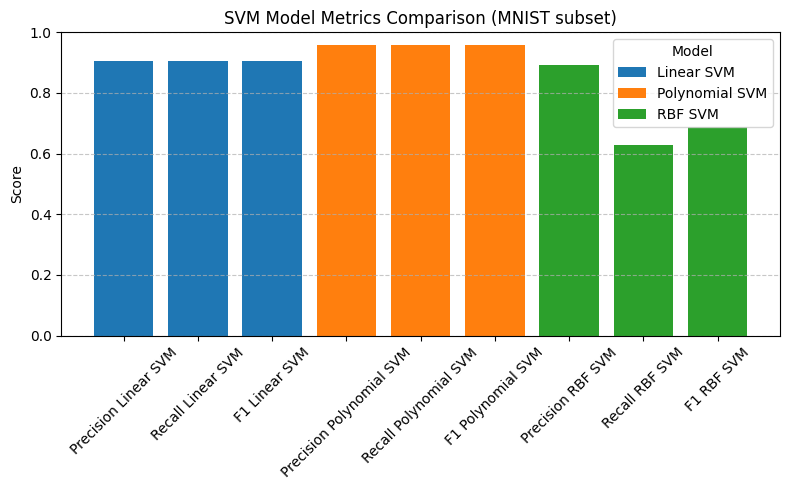

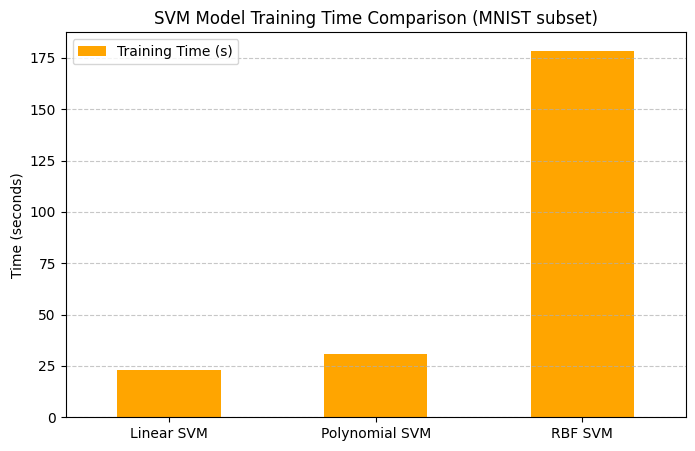

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame(results).T
display(results_df)

metrics_df = results_df[["Precision", "Recall", "F1"]]

metrics_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(8,5))
for model in metrics_df.index:
    subset = metrics_melted[metrics_melted['index'] == model]
    plt.bar(subset['Metric'] + " " + model, subset['Score'], label=model)

plt.title("SVM Model Metrics Comparison (MNIST subset)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

time_df = results_df[["Training Time (s)"]]
time_df.plot(kind='bar', figsize=(8,5), color='orange')
plt.title("SVM Model Training Time Comparison (MNIST subset)")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()
